In [1]:
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import yaml
import json
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

In [2]:
plt.rcParams['figure.figsize'] = 20, 15
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['figure.facecolor'] = 'white'

sparql_base = 'sparql/'

In [3]:
with open('config.yaml') as file:
    config = yaml.load(file, Loader=yaml.SafeLoader)

In [5]:
query_string = open(sparql_base + 'pages.rq', 'r').read()
sparql = SPARQLWrapper(config['sparql_enpoint'])
sparql.setQuery(query_string)
sparql.setReturnFormat(JSON)

res = sparql.query().convert()

Construct the graph

In [6]:
g = nx.DiGraph()
for r in res['results']['bindings']:
    p_type = r['pageType1']['value']
    g.add_node(
        r['label1']['value'],
        exists=(r['exists1']['value'] == 'true'),
        is_restart=(
                p_type == 'Typ strony Gry:Restart' or
                p_type == 'Typ strony Gry:Śmierć' or
                p_type == 'Typ strony Gry:Początek trybu'
        )
    )
    for target in r['links']['value'].split('|'):
        if target == '':
            continue
        g.add_edge(r['label1']['value'], target)

# restrict the graph to pages that exist
g = g.subgraph([v for v, exists in g.nodes(data='exists') if exists]).copy()

Remove links to restarts

In [7]:
g_no_restart = g.copy()
e_to_remove = []
for v, is_restart in g_no_restart.nodes(data='is_restart'):
    if is_restart:
        e_to_remove.extend(g_no_restart.in_edges(v))

g_no_restart.remove_edges_from(e_to_remove)

Distance from source

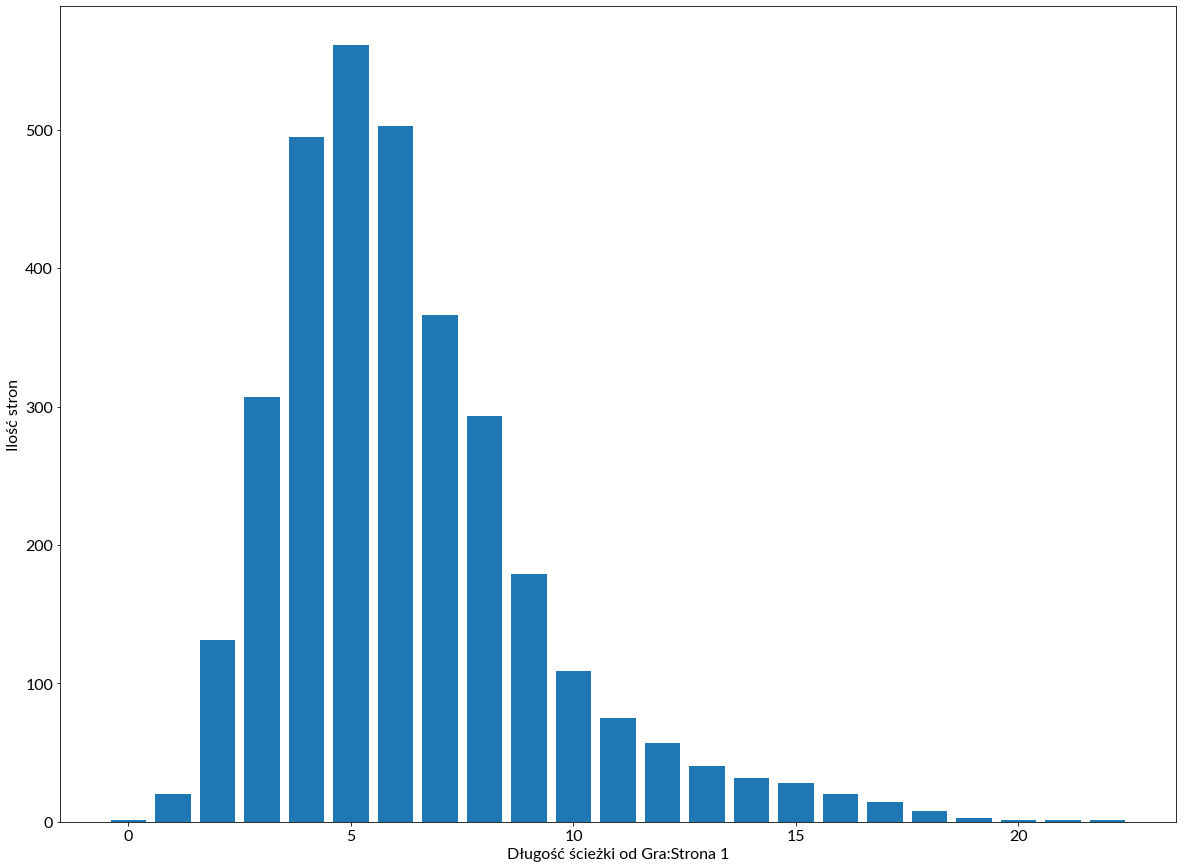

In [8]:
def calc_paths(graph):
    paths = nx.single_source_bellman_ford(graph, 'Gra:Strona 1')[0]
    lengths = np.array([v for v in paths.values()])
    lengths_hist = np.bincount(lengths)
    plt.bar(range(len(lengths_hist)), lengths_hist)
    plt.ylabel('Ilość stron')
    plt.xlabel('Długość ścieżki od Gra:Strona 1')

    return paths

paths_g = calc_paths(g)

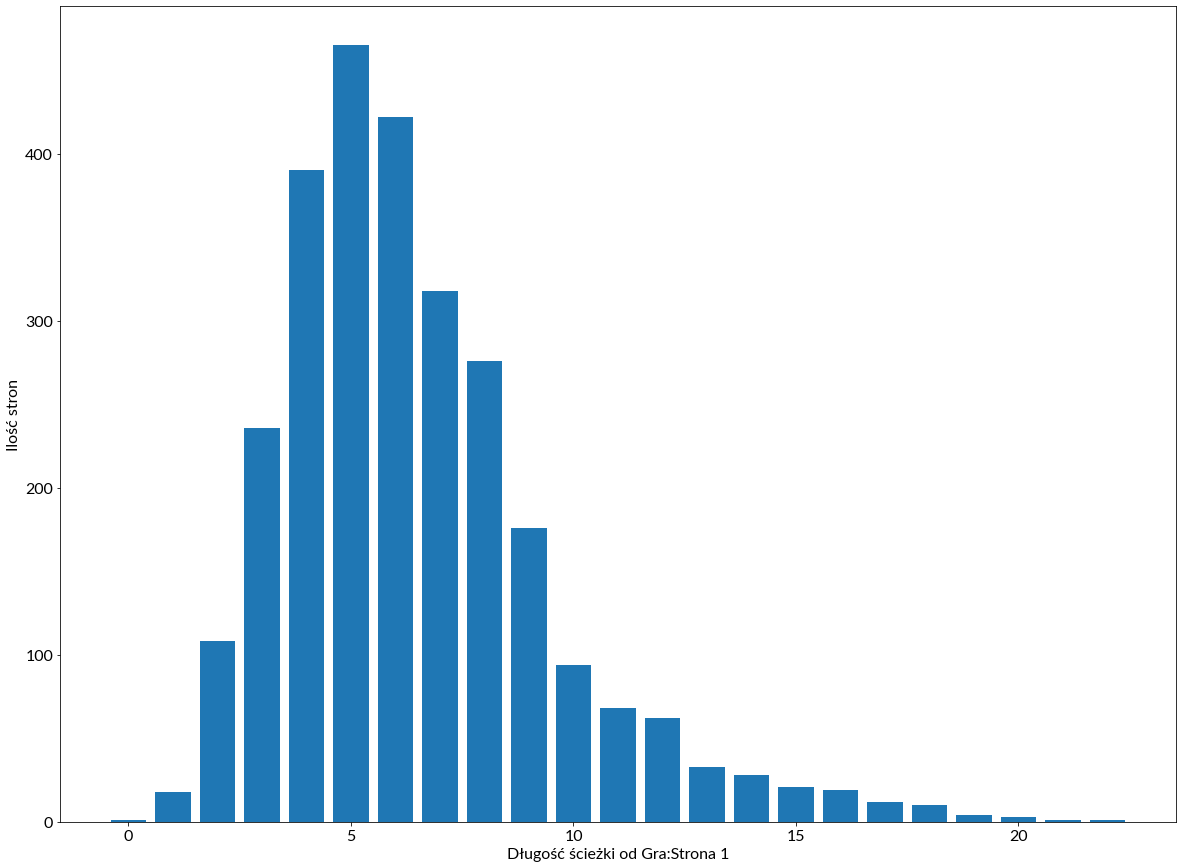

In [9]:
paths_no_restart = calc_paths(g_no_restart)

In [14]:
df = pd.DataFrame([(k, v) for k, v in paths_g.items()], columns=['page', 'path_len']).set_index('page')
df = df.sort_index()
df.to_csv('export/paths.tsv', sep='\t')

PageRank

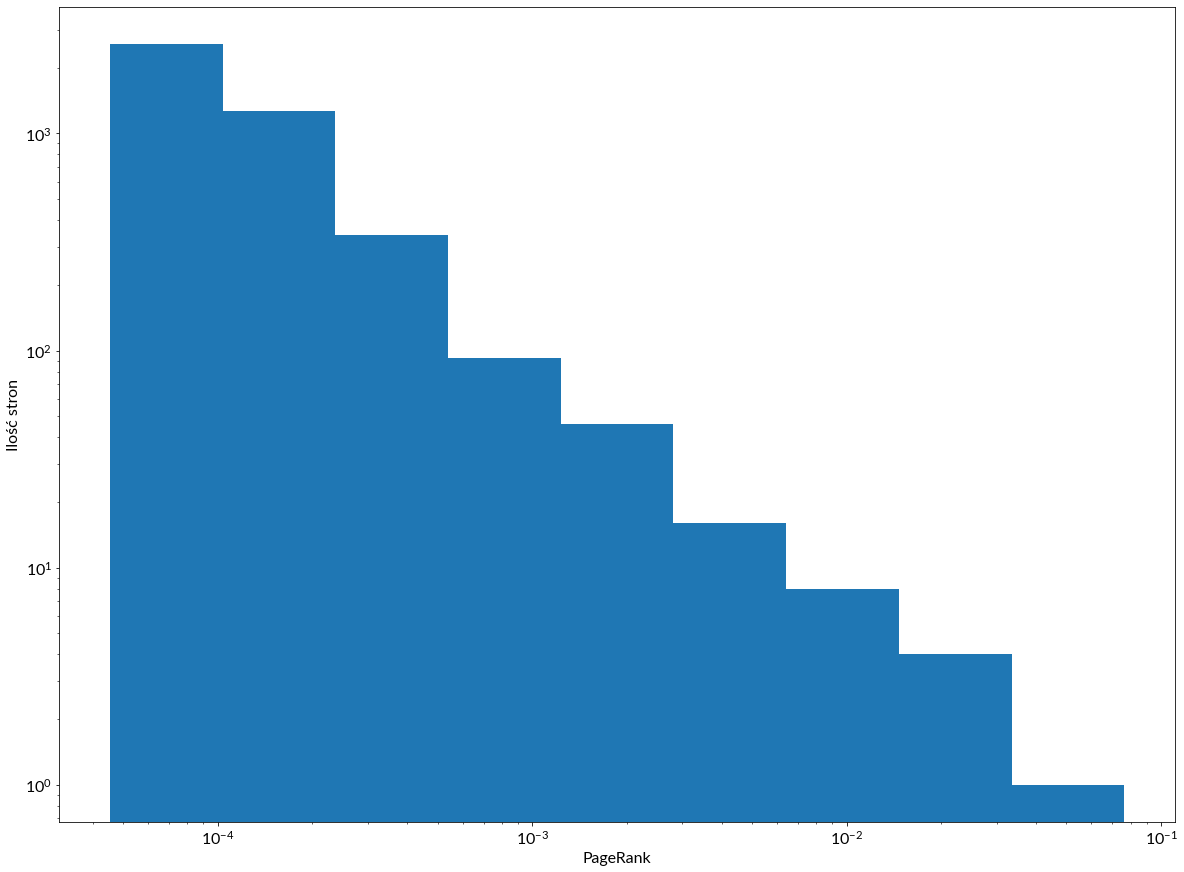

In [14]:
pagerank = nx.pagerank_scipy(g)
pr_numpy = np.array(list(pagerank.values()))
plt.hist(
    pr_numpy,
    bins=np.logspace(np.log10(np.min(pr_numpy)), np.log10(np.max(pr_numpy)), 10),
)
plt.yscale('log')
plt.ylabel('Ilość stron')
plt.xscale('log')
plt.xlabel('PageRank')
plt.savefig('img/pagerank.svg')

